In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from supportfunctions import PDESolver_2d, finiteDiff
from solver_2d import false_transient_one_iteration_python
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one, solve_smooth
from solver import pde_solve
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from multiprocessing import Pool
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams["figure.edgecolor"] = "w"
mpl.rcParams['figure.facecolor'] = "w"
mpl.rcParams["savefig.dpi"] = 300

# Simple version
$$
\begin{aligned}
0 = \max_{\mathcal{E}} & - \delta \phi(y) + \delta \eta log(\mathcal{E}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \theta \mathcal{E}) \\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$

$$
\mathcal{E}^* = -\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}
$$

$$
\begin{aligned}
0 = & - \delta \phi(y) + \delta \eta log(-\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 )  - \delta \eta\\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$


# Adding robustness and ambiguity:

Process:

$$
dY_t^1  = Y_t^2 dt
$$

$$
dY_t^2 =   - \lambda Y_t^2 dt + \lambda \theta \mathcal{E} dt
$$


HJB:

$$
\begin{aligned}
0 = \max_{\mathcal{E}} \min_{\omega_\ell } & - \delta \phi(y_1, y_2) + \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \sum_{\ell}^L 
\omega_\ell  \theta_\ell \mathcal{E}) \\ 
& + \frac{(\eta - 1)}{\delta} \left(\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\} \right) y_2 \\
& + \xi_a \sum_{\ell}^L \omega_\ell (\log \omega_\ell - \log \pi^a_i)
\end{aligned}
$$

$$
    \hat \pi^{a,*}_i \propto \pi_i^a \exp\left( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E} \right)
$$

and
$$
\mathcal{E}^* = - \frac{\eta}{\frac{\partial \phi }{\partial y_2} \lambda \sum_i \hat\pi^a_i\theta_i}
$$
Plug back in:

$$
\begin{aligned}
0 = \max_{\mathcal{E}}  & - \delta \phi(y) +  \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2) \\ 
& + \frac{(\eta - 1)}{\delta} (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2 \\
& - \xi_a  \log \left(\sum_i\hat \pi^a_i \exp( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E}) \right)
\end{aligned}
$$

$$
\phi(\bar y_1, y_2) \approx  - \xi_p \log \left (\sum_m \pi_m^p \exp\left[-\frac{1}{\xi_p }\phi_m(\bar y_1, y_2) \right] \right) 
$$

In [2]:
# parameters
δ = 0.01
η = 0.032
ξa = 0.01
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
θ = np.mean(θ_list)
σy = 1.2*θ
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.linspace(0., 1./3, 20)
# y grid
# λ = np.log(2)/6
λ = 20

In [3]:
y1_step = .02
y1_grid = np.arange(0., 4., y1_step)

y2_step = .001
y2_grid = np.arange(0., .05, y2_step)

(y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
stateSpace = np.hstack([y1_mat.reshape(-1,1, order='F'), y2_mat.reshape(-1,1,order='F')])
hy1 = y1_grid[1] - y1_grid[0]
hy2 = y2_grid[1] - y2_grid[0]
n_y1 = len(y1_grid)
n_y2 = len(y2_grid)

In [4]:
def solve_prep(y1_mat, y2_mat, γ3, tol=1e-7, ϵ=1, max_iter=2000, fraction=0.05):
    πa_o = np.ones((len(θ_list), n_y1, n_y2))/len(θ_list)
    θ_mat = np.zeros((len(θ_list), n_y1, n_y2))
    for i in range(len(θ_list)):
        θ_mat[i] = θ_list[i]
    πa = πa_o
    dΛ1 = γ1 + γ2*y1_mat + γ3*(y1_mat - ȳ)*(y1_mat >ȳ)
    ems_new = η*np.ones(y1_mat.shape)
    ems_old = ems_new
    episode = 0
    lhs_error = 0.5
    while lhs_error > tol and episode  < max_iter:
        if episode ==0:
            v0 =  - η*((y1_mat+y2_mat) + (y1_mat+y2_mat)**2)
        else:
            vold = v0.copy()
        v0_dy1 = derivatives_2d(v0,0,1,hy1)
        v0_dy2 = derivatives_2d(v0,1,1,hy2)
        # updating controls
        ems_new =  - η/(v0_dy2*λ*np.sum(θ_mat*πa, axis=0))
        ems_new[ems_new <= 1e-10] = 1e-10
        ems = ems_new*fraction + ems_old*(1 - fraction)
        
        weight = np.array([-1/ξa*v0_dy2*λ*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πa = πa_o*np.exp(weight)
#         πa[πa<1e-15] = 1e-15
        πa = πa/np.sum(πa, axis=0)
        
#         print(np.min(ems))
        # HJB coefficient
        A =  -δ*np.ones(y1_mat.shape)
        B_y1 =  y2_mat
        B_y2 = λ*( - y2_mat + ems*np.sum(θ_mat*πa, axis=0))
        C_yy1 = np.zeros(y1_mat.shape)
        C_yy2 = np.zeros(y1_mat.shape)
        D = η*np.log(ems) +  (η-1)/δ*dΛ1*y2_mat + ξa*np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0) 
        # PDE solver
        solve_start = time.time()
        out = PDESolver_2d(stateSpace, A, B_y1, B_y2, C_yy1, C_yy2, D, v0, ϵ, solverType = 'False Transient')
        out_comp = out[2].reshape(v0.shape,order = "F")
        rhs = A*v0 + B_y1*v0_dy1 + B_y2*v0_dy2  + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0)/ϵ))
        #     if episode % 1 == 0:
#         print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems_old = ems
#         print("End of PDE solver, takes time: {}".format(time.time() - solve_start))
    
    print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
    result = dict(v0=v0, ems=ems, πa=πa)
    return result

In [ ]:
def ode_y_parallel(args_list):
    with Pool() as p:
        res_list = p.starmap(solve_prep, args_list)
    return res_list        

def postjump_list(args_list):
    res_list = ode_y_parallel(args_list)
    ϕ_list = np.zeros((len(γ3_list), len(y1_grid), len(y2_grid)))
    ems_list = np.zeros((len(γ3_list), len(y1_grid), len(y2_grid)))
    for j in range(len(γ3_list)):
        ϕ_list[j] = res_list[j]['v0']
        ems_list[j] = res_list[j]['ems']
        
    return ϕ_list, ems_list

args_list_test  = []
for γ3_i in γ3_list:
    args_iter = (y1_mat, y2_mat, γ3_i, 1e-6, 0.001, 2000, 0.05)
    args_list_test.append(args_iter)
ϕ_list, ems_list = postjump_list(args_list_test)

In [8]:
np.save(f"v_list_{λ}", ϕ_list)
np.save(f"e_list_{λ}", ems_list)

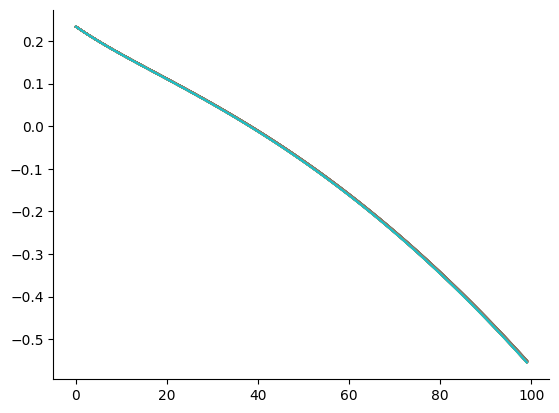

In [9]:
plt.plot(ϕ_list[0])
plt.show()

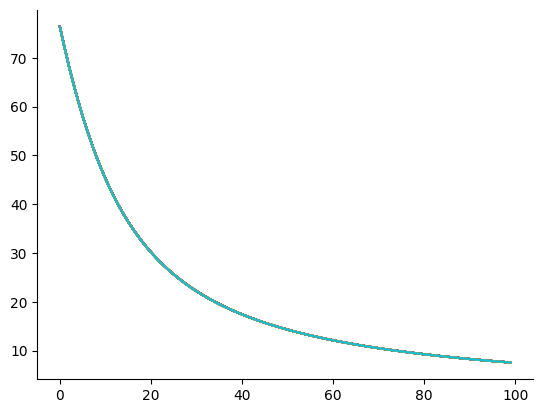

In [10]:
plt.plot(ems_list[0])
# plt.ylim(-6,6)
plt.show()

In [12]:
y1_grid_cap = np.arange(0., 2.1 + y1_step, y1_step)
loc_2 = np.abs(y1_grid - 2.).argmin()
ξp = 1.
ϵ = 0.001
max_iter = 5000
dmg_weight = np.ones(len(γ3_list)) / len(γ3_list)
ϕ_weight = np.average(np.exp(-1 / ξp * ϕ_list), axis=0, weights=dmg_weight)

ϕ_equiv = -ξp * np.log(ϕ_weight)

(y1_mat_cap, y2_mat_cap) = np.meshgrid(y1_grid_cap, y2_grid, indexing='ij')
dy1 = y1_grid_cap[1] - y1_grid[0]
dy2 = y2_grid[1] - y2_grid[0]
num_y1 = len(y1_grid_cap)
num_y2 = len(y2_grid)
πd_o = np.ones((len(γ3_list), num_y1, num_y2)) / len(γ3_list)
πa_o = np.ones((len(θ_list), num_y1, num_y2)) / len(θ_list)
θ_mat = np.zeros((len(θ_list), num_y1, num_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
dΛ1 = γ1 + γ2 * y1_mat_cap

r1 = 1.5
r2 = 2.5
y_lower = 1.5
Intensity = r1 * (np.exp(r2 / 2 * (y1_mat_cap - y_lower)**2) -
                  1) * (y1_mat_cap >= y_lower)

# initiate v and control
tol = 1e-6
ems = η
ems_old = ems
lhs_error = 1
episode = 0
v0 = ϕ_equiv[:num_y1]
v_m = np.zeros(πd_o.shape)
for i in range(len(γ3_list)):
    v_m[i] = ϕ_list[i][loc_2]

while lhs_error > tol and episode < max_iter:
    v0_old = v0.copy()
    v0_dy1 = derivatives_2d(v0, 0, 1, hy1)
    v0_dy2 = derivatives_2d(v0, 1, 1, hy2)
    # updating controls
    weight = np.array([-1 / ξa * v0_dy2 * λ * ems_old * θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πa = πa_o * np.exp(weight)
    πa[πa < 1e-15] = 1e-15
    πa = πa / np.sum(πa, axis=0)
    ems_new = -η / (v0_dy2 * λ * np.sum(θ_mat * πa, axis=0))
    ems_new[ems_new <= 1e-15] = 1e-15
    ems = ems_new * 0.01 + ems_old * 0.99
    #     print(np.min(ems))
    g_m = np.exp(1 / ξp * (v0 - v_m))
    # HJB coefficient
    A = -δ * np.ones(y1_mat_cap.shape) - Intensity * np.sum(πd_o * g_m, axis=0)
    B_y1 = y2_mat_cap
    B_y2 = λ * (-y2_mat_cap + ems * np.sum(θ_mat * πa, axis=0))
    C_yy1 = np.zeros(y1_mat_cap.shape)
    C_yy2 = np.zeros(y1_mat_cap.shape)
    D = η * np.log(ems) + (η - 1) / δ * dΛ1 * y2_mat_cap + ξa * np.sum(
        πa * (np.log(πa) - np.log(πa_o)), axis=0) + Intensity * np.sum(
            πd_o * g_m * v_m, axis=0) + ξp * Intensity * np.sum(
                πd_o * (1 - g_m + g_m * np.log(g_m)), axis=0)
    phi_mat = false_transient_one_iteration_python(
        A,
        B_y1,
        B_y2,
        C_yy1,
        C_yy2,
        D,
        v0,
        ϵ,
        hy1,
        hy2,
        bc=(np.zeros(num_y2), ϕ_equiv[num_y1 - 1], np.zeros(num_y1),
            np.zeros(num_y1)),
        impose_bc=(False, False, False, False))

    rhs = A * phi_mat + B_y1 * v0_dy1 + B_y2 * v0_dy2 + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((phi_mat - v0_old) / ϵ))
    v0 = phi_mat
    ems_old = ems
    episode += 1
    print('Episode: {:d}\t lhs error: {:.12f}\t rhs error: {:.12f}'.format(episode, lhs_error, rhs_error))

Episode: 1	 lhs error: 0.076725163976	 rhs error: 0.080506912625
Episode: 2	 lhs error: 0.089828171677	 rhs error: 0.093578697107
Episode: 3	 lhs error: 0.097967781443	 rhs error: 0.101686472378
Episode: 4	 lhs error: 0.103617316250	 rhs error: 0.107305447345
Episode: 5	 lhs error: 0.107775076087	 rhs error: 0.111433667801
Episode: 6	 lhs error: 0.110946742558	 rhs error: 0.114574272548
Episode: 7	 lhs error: 0.113422116909	 rhs error: 0.117016554324
Episode: 8	 lhs error: 0.115380405517	 rhs error: 0.118942110937
Episode: 9	 lhs error: 0.116935795773	 rhs error: 0.120472371844
Episode: 10	 lhs error: 0.118163082796	 rhs error: 0.121692535750
Episode: 11	 lhs error: 0.119117246063	 rhs error: 0.122664701144
Episode: 12	 lhs error: 0.119852518169	 rhs error: 0.123435496388
Episode: 13	 lhs error: 0.120436062175	 rhs error: 0.124040658030
Episode: 14	 lhs error: 0.120943638400	 rhs error: 0.124507857502
Episode: 15	 lhs error: 0.121428380843	 rhs error: 0.124858624493
Episode: 16	 lhs er

Episode: 125	 lhs error: 0.104692662316	 rhs error: 0.118998495746
Episode: 126	 lhs error: 0.104682516852	 rhs error: 0.118617747127
Episode: 127	 lhs error: 0.104671930292	 rhs error: 0.118229988971
Episode: 128	 lhs error: 0.104660912041	 rhs error: 0.117834823728
Episode: 129	 lhs error: 0.104649474331	 rhs error: 0.117431925872
Episode: 130	 lhs error: 0.104637632209	 rhs error: 0.117021090182
Episode: 131	 lhs error: 0.104625403643	 rhs error: 0.116602294115
Episode: 132	 lhs error: 0.104612809700	 rhs error: 0.116175776923
Episode: 133	 lhs error: 0.104599874801	 rhs error: 0.115742137638
Episode: 134	 lhs error: 0.104586626999	 rhs error: 0.115302452200
Episode: 135	 lhs error: 0.104573098246	 rhs error: 0.114858406051
Episode: 136	 lhs error: 0.104559324490	 rhs error: 0.114412431172
Episode: 137	 lhs error: 0.104545345393	 rhs error: 0.113967825004
Episode: 138	 lhs error: 0.104531203358	 rhs error: 0.113528812892
Episode: 139	 lhs error: 0.104516941575	 rhs error: 0.11347270

Episode: 249	 lhs error: 0.104860778709	 rhs error: 0.119210372301
Episode: 250	 lhs error: 0.104863833685	 rhs error: 0.119265186366
Episode: 251	 lhs error: 0.104866761231	 rhs error: 0.119315574695
Episode: 252	 lhs error: 0.104869562527	 rhs error: 0.119361402128
Episode: 253	 lhs error: 0.104872237841	 rhs error: 0.119402525742
Episode: 254	 lhs error: 0.104874786512	 rhs error: 0.119438795549
Episode: 255	 lhs error: 0.104877206956	 rhs error: 0.119470055242
Episode: 256	 lhs error: 0.104879496681	 rhs error: 0.119496142980
Episode: 257	 lhs error: 0.104881652324	 rhs error: 0.119516892214
Episode: 258	 lhs error: 0.104883669698	 rhs error: 0.119532132581
Episode: 259	 lhs error: 0.104885543863	 rhs error: 0.119541690890
Episode: 260	 lhs error: 0.104887269207	 rhs error: 0.119545392185
Episode: 261	 lhs error: 0.104888839549	 rhs error: 0.119543060946
Episode: 262	 lhs error: 0.104890248246	 rhs error: 0.119534522425
Episode: 263	 lhs error: 0.104891488327	 rhs error: 0.11951960

Episode: 373	 lhs error: 0.104191194516	 rhs error: 0.105540188888
Episode: 374	 lhs error: 0.104181350466	 rhs error: 0.105514209988
Episode: 375	 lhs error: 0.104171500576	 rhs error: 0.105493124538
Episode: 376	 lhs error: 0.104161644881	 rhs error: 0.105471924229
Episode: 377	 lhs error: 0.104151783415	 rhs error: 0.105450617188
Episode: 378	 lhs error: 0.104141916217	 rhs error: 0.105429211198
Episode: 379	 lhs error: 0.104132043331	 rhs error: 0.105407713708
Episode: 380	 lhs error: 0.104122164804	 rhs error: 0.105386131842
Episode: 381	 lhs error: 0.104112280696	 rhs error: 0.105364472413
Episode: 382	 lhs error: 0.104102391069	 rhs error: 0.105342741927
Episode: 383	 lhs error: 0.104092495997	 rhs error: 0.105320946594
Episode: 384	 lhs error: 0.104082595564	 rhs error: 0.105299092342
Episode: 385	 lhs error: 0.104072689861	 rhs error: 0.105277184823
Episode: 386	 lhs error: 0.104062778991	 rhs error: 0.105255229425
Episode: 387	 lhs error: 0.104052863067	 rhs error: 0.10523323

Episode: 497	 lhs error: 0.108134070961	 rhs error: 0.114265496393
Episode: 498	 lhs error: 0.105772267688	 rhs error: 0.111516866241
Episode: 499	 lhs error: 0.107805112048	 rhs error: 0.107369031133
Episode: 500	 lhs error: 0.105591534476	 rhs error: 0.114450358593
Episode: 501	 lhs error: 0.104256985962	 rhs error: 0.108360136034
Episode: 502	 lhs error: 0.104648101415	 rhs error: 0.106590753735
Episode: 503	 lhs error: 0.107800486331	 rhs error: 0.108110535612
Episode: 504	 lhs error: 0.105098868492	 rhs error: 0.114363119587
Episode: 505	 lhs error: 0.108104766802	 rhs error: 0.109049565433
Episode: 506	 lhs error: 0.106033233070	 rhs error: 0.113803429603
Episode: 507	 lhs error: 0.104564992361	 rhs error: 0.107964136094
Episode: 508	 lhs error: 0.104528893768	 rhs error: 0.105793342140
Episode: 509	 lhs error: 0.104767023460	 rhs error: 0.106850832820
Episode: 510	 lhs error: 0.107032537612	 rhs error: 0.103878864965
Episode: 511	 lhs error: 0.107022932602	 rhs error: 0.11384371

Episode: 621	 lhs error: 0.102324756017	 rhs error: 0.103346966347
Episode: 622	 lhs error: 0.102290794927	 rhs error: 0.103202762571
Episode: 623	 lhs error: 0.102239877606	 rhs error: 0.103081987309
Episode: 624	 lhs error: 0.102264945664	 rhs error: 0.103263748276
Episode: 625	 lhs error: 0.102282747040	 rhs error: 0.103121409464
Episode: 626	 lhs error: 0.102257246713	 rhs error: 0.102987468680
Episode: 627	 lhs error: 0.102238252562	 rhs error: 0.103141999705
Episode: 628	 lhs error: 0.102263983336	 rhs error: 0.103044922490
Episode: 629	 lhs error: 0.102243157436	 rhs error: 0.102911625891
Episode: 630	 lhs error: 0.102219789218	 rhs error: 0.103006620708
Episode: 631	 lhs error: 0.102209528022	 rhs error: 0.102952815713
Episode: 632	 lhs error: 0.102180905768	 rhs error: 0.102844542504
Episode: 633	 lhs error: 0.102153609617	 rhs error: 0.102880212906
Episode: 634	 lhs error: 0.102136227772	 rhs error: 0.102845595495
Episode: 635	 lhs error: 0.102111477682	 rhs error: 0.10277123

Episode: 745	 lhs error: 0.101680077402	 rhs error: 0.107120843076
Episode: 746	 lhs error: 0.101839096372	 rhs error: 0.105979389296
Episode: 747	 lhs error: 0.101956251486	 rhs error: 0.105738122416
Episode: 748	 lhs error: 0.102088232163	 rhs error: 0.106056376191
Episode: 749	 lhs error: 0.102024558240	 rhs error: 0.104983365930
Episode: 750	 lhs error: 0.101868654396	 rhs error: 0.105638238187
Episode: 751	 lhs error: 0.101895647986	 rhs error: 0.105053986995
Episode: 752	 lhs error: 0.101711910134	 rhs error: 0.104860106119
Episode: 753	 lhs error: 0.101567572260	 rhs error: 0.105059116609
Episode: 754	 lhs error: 0.101556787647	 rhs error: 0.104192702016
Episode: 755	 lhs error: 0.101392590468	 rhs error: 0.104833045811
Episode: 756	 lhs error: 0.101318266904	 rhs error: 0.104276138571
Episode: 757	 lhs error: 0.101257005719	 rhs error: 0.104458030448
Episode: 758	 lhs error: 0.101197602579	 rhs error: 0.104795813627
Episode: 759	 lhs error: 0.101236227958	 rhs error: 0.10439695

Episode: 869	 lhs error: 0.104053903971	 rhs error: 0.117997408298
Episode: 870	 lhs error: 0.103180560142	 rhs error: 0.112328177446
Episode: 871	 lhs error: 0.103764607247	 rhs error: 0.113582056038
Episode: 872	 lhs error: 0.105558781328	 rhs error: 0.130506025284
Episode: 873	 lhs error: 0.102334658983	 rhs error: 0.115215591805
Episode: 874	 lhs error: 0.104775553398	 rhs error: 0.117929727658
Episode: 875	 lhs error: 0.104693557884	 rhs error: 0.115771193534
Episode: 876	 lhs error: 0.102075799319	 rhs error: 0.114337981983
Episode: 877	 lhs error: 0.105684437443	 rhs error: 0.117636849139
Episode: 878	 lhs error: 0.106199842461	 rhs error: 0.122702272792
Episode: 879	 lhs error: 0.102049673428	 rhs error: 0.115717009724
Episode: 880	 lhs error: 0.103290309687	 rhs error: 0.115347863471
Episode: 881	 lhs error: 0.103186928372	 rhs error: 0.108083759711
Episode: 882	 lhs error: 0.103318007062	 rhs error: 0.119547708937
Episode: 883	 lhs error: 0.102667555608	 rhs error: 0.11101315

Episode: 993	 lhs error: 0.100144193005	 rhs error: 0.117723613558
Episode: 994	 lhs error: 0.100133878711	 rhs error: 0.117544592501
Episode: 995	 lhs error: 0.100121701120	 rhs error: 0.117353063819
Episode: 996	 lhs error: 0.100109738974	 rhs error: 0.117152390220
Episode: 997	 lhs error: 0.100101059070	 rhs error: 0.116938408799
Episode: 998	 lhs error: 0.100099548207	 rhs error: 0.116709461154
Episode: 999	 lhs error: 0.100097882370	 rhs error: 0.116461457684
Episode: 1000	 lhs error: 0.100097105469	 rhs error: 0.116189176870
Episode: 1001	 lhs error: 0.100097293768	 rhs error: 0.115884343877
Episode: 1002	 lhs error: 0.100099499816	 rhs error: 0.115533497439
Episode: 1003	 lhs error: 0.100105662865	 rhs error: 0.115112450597
Episode: 1004	 lhs error: 0.100121514295	 rhs error: 0.114571522449
Episode: 1005	 lhs error: 0.100242530886	 rhs error: 0.113784619896
Episode: 1006	 lhs error: 0.101411277747	 rhs error: 0.112278595098
Episode: 1007	 lhs error: 0.104398867596	 rhs error: 0.

Episode: 1117	 lhs error: 0.099371108078	 rhs error: 0.127490283042
Episode: 1118	 lhs error: 0.099441389300	 rhs error: 0.131038923860
Episode: 1119	 lhs error: 0.099508708366	 rhs error: 0.135091727684
Episode: 1120	 lhs error: 0.099527314771	 rhs error: 0.139643808970
Episode: 1121	 lhs error: 0.099353032253	 rhs error: 0.144228035447
Episode: 1122	 lhs error: 0.099595309183	 rhs error: 0.146597442737
Episode: 1123	 lhs error: 0.100125737972	 rhs error: 0.142566388531
Episode: 1124	 lhs error: 0.100264732819	 rhs error: 0.131529351856
Episode: 1125	 lhs error: 0.099911549352	 rhs error: 0.116693011443
Episode: 1126	 lhs error: 0.099465618423	 rhs error: 0.110589684127
Episode: 1127	 lhs error: 0.099115413171	 rhs error: 0.110792292020
Episode: 1128	 lhs error: 0.098845432865	 rhs error: 0.110769309912
Episode: 1129	 lhs error: 0.098689176177	 rhs error: 0.110685311855
Episode: 1130	 lhs error: 0.098671746856	 rhs error: 0.110589313745
Episode: 1131	 lhs error: 0.098678797311	 rhs er

Episode: 1241	 lhs error: 0.097587430948	 rhs error: 0.115647361793
Episode: 1242	 lhs error: 0.097594662088	 rhs error: 0.115688545113
Episode: 1243	 lhs error: 0.097602059217	 rhs error: 0.115726979688
Episode: 1244	 lhs error: 0.097609610233	 rhs error: 0.115762800801
Episode: 1245	 lhs error: 0.097617303473	 rhs error: 0.115796159039
Episode: 1246	 lhs error: 0.097625127742	 rhs error: 0.115827217716
Episode: 1247	 lhs error: 0.097633072379	 rhs error: 0.115856150071
Episode: 1248	 lhs error: 0.097641127351	 rhs error: 0.115883136071
Episode: 1249	 lhs error: 0.097649283305	 rhs error: 0.115908358657
Episode: 1250	 lhs error: 0.097657531528	 rhs error: 0.115931999333
Episode: 1251	 lhs error: 0.097665863807	 rhs error: 0.115954233055
Episode: 1252	 lhs error: 0.097674272243	 rhs error: 0.115975222351
Episode: 1253	 lhs error: 0.097682749044	 rhs error: 0.115995110637
Episode: 1254	 lhs error: 0.097691286319	 rhs error: 0.116014014649
Episode: 1255	 lhs error: 0.097699875859	 rhs er

Episode: 1365	 lhs error: 0.098556901268	 rhs error: 0.105757495008
Episode: 1366	 lhs error: 0.099249481884	 rhs error: 0.107213218968
Episode: 1367	 lhs error: 0.102570305589	 rhs error: 0.111939652488
Episode: 1368	 lhs error: 0.109575362330	 rhs error: 0.114060320339
Episode: 1369	 lhs error: 0.111612528145	 rhs error: 0.131203799140
Episode: 1370	 lhs error: 0.103508778764	 rhs error: 0.118949723331
Episode: 1371	 lhs error: 0.107701939699	 rhs error: 0.124469502273
Episode: 1372	 lhs error: 0.103840100193	 rhs error: 0.117132877365
Episode: 1373	 lhs error: 0.111757426943	 rhs error: 0.110744022926
Episode: 1374	 lhs error: 0.101722771111	 rhs error: 0.123386657640
Episode: 1375	 lhs error: 0.103709050616	 rhs error: 0.119712906181
Episode: 1376	 lhs error: 0.107891187941	 rhs error: 0.140891790725
Episode: 1377	 lhs error: 0.105663319724	 rhs error: 0.106437615019
Episode: 1378	 lhs error: 0.109785902524	 rhs error: 0.115487241800
Episode: 1379	 lhs error: 0.110395024888	 rhs er

Episode: 1489	 lhs error: 0.097006838995	 rhs error: 0.611905906802
Episode: 1490	 lhs error: 0.097012420319	 rhs error: 0.617952933683
Episode: 1491	 lhs error: 0.097018224316	 rhs error: 0.622350498879
Episode: 1492	 lhs error: 0.097024710774	 rhs error: 0.625559567638
Episode: 1493	 lhs error: 0.097032275454	 rhs error: 0.628044827504
Episode: 1494	 lhs error: 0.097041253565	 rhs error: 0.630294081667
Episode: 1495	 lhs error: 0.097051905640	 rhs error: 0.632841313902
Episode: 1496	 lhs error: 0.097064357621	 rhs error: 0.636287474783
Episode: 1497	 lhs error: 0.097078459559	 rhs error: 0.641314021584
Episode: 1498	 lhs error: 0.097093548865	 rhs error: 0.648682827501
Episode: 1499	 lhs error: 0.097108064287	 rhs error: 0.659198678034
Episode: 1500	 lhs error: 0.097119163892	 rhs error: 0.673614663031
Episode: 1501	 lhs error: 0.097122570976	 rhs error: 0.692458489354
Episode: 1502	 lhs error: 0.097113298791	 rhs error: 0.715787568858
Episode: 1503	 lhs error: 0.097087570584	 rhs er

Episode: 1613	 lhs error: 0.104799327505	 rhs error: 0.133586283483
Episode: 1614	 lhs error: 0.102418405347	 rhs error: 0.129705160527
Episode: 1615	 lhs error: 0.100765325868	 rhs error: 0.131962028021
Episode: 1616	 lhs error: 0.100224555546	 rhs error: 0.229850345768
Episode: 1617	 lhs error: 0.099095449739	 rhs error: 0.222310365429
Episode: 1618	 lhs error: 0.098009237954	 rhs error: 0.247349826092
Episode: 1619	 lhs error: 0.097714728219	 rhs error: 0.241154372538
Episode: 1620	 lhs error: 0.097583644342	 rhs error: 0.230262525247
Episode: 1621	 lhs error: 0.097051480979	 rhs error: 0.211504178780
Episode: 1622	 lhs error: 0.097096139389	 rhs error: 0.195304716912
Episode: 1623	 lhs error: 0.096843894104	 rhs error: 0.180771777626
Episode: 1624	 lhs error: 0.100859553263	 rhs error: 0.167677592722
Episode: 1625	 lhs error: 0.097379376866	 rhs error: 0.127142972070
Episode: 1626	 lhs error: 0.096654141566	 rhs error: 0.128691311959
Episode: 1627	 lhs error: 0.096651234081	 rhs er

Episode: 1737	 lhs error: 0.095827081404	 rhs error: 0.120107016414
Episode: 1738	 lhs error: 0.095823205634	 rhs error: 0.120070039671
Episode: 1739	 lhs error: 0.095819287683	 rhs error: 0.120016886035
Episode: 1740	 lhs error: 0.095815424104	 rhs error: 0.119945358890
Episode: 1741	 lhs error: 0.095815627378	 rhs error: 0.119852931942
Episode: 1742	 lhs error: 0.095816347549	 rhs error: 0.119736689881
Episode: 1743	 lhs error: 0.095817666452	 rhs error: 0.119593255822
Episode: 1744	 lhs error: 0.095819682531	 rhs error: 0.119418701991
Episode: 1745	 lhs error: 0.095822515056	 rhs error: 0.119208438934
Episode: 1746	 lhs error: 0.095826309608	 rhs error: 0.118957076970
Episode: 1747	 lhs error: 0.095831245312	 rhs error: 0.118658251467
Episode: 1748	 lhs error: 0.095837544439	 rhs error: 0.118304400458
Episode: 1749	 lhs error: 0.095845485283	 rhs error: 0.117886478940
Episode: 1750	 lhs error: 0.103558593658	 rhs error: 0.117393519687
Episode: 1751	 lhs error: 0.102265584812	 rhs er

Episode: 1861	 lhs error: 0.101713991896	 rhs error: 0.111685094874
Episode: 1862	 lhs error: 0.099043060716	 rhs error: 0.121883538530
Episode: 1863	 lhs error: 0.101530888245	 rhs error: 0.112194669113
Episode: 1864	 lhs error: 0.100115336020	 rhs error: 0.126386470349
Episode: 1865	 lhs error: 0.100254225267	 rhs error: 0.111985783938
Episode: 1866	 lhs error: 0.101226030572	 rhs error: 0.128732347487
Episode: 1867	 lhs error: 0.101721307745	 rhs error: 0.111144137896
Episode: 1868	 lhs error: 0.103623148140	 rhs error: 0.149489931990
Episode: 1869	 lhs error: 0.099464552454	 rhs error: 0.161853296912
Episode: 1870	 lhs error: 0.101325190142	 rhs error: 0.119646252749
Episode: 1871	 lhs error: 0.108900284888	 rhs error: 0.144947772139
Episode: 1872	 lhs error: 0.100229911342	 rhs error: 0.123458288757
Episode: 1873	 lhs error: 0.101319733760	 rhs error: 0.133443920652
Episode: 1874	 lhs error: 0.104095512924	 rhs error: 0.113405499172
Episode: 1875	 lhs error: 0.105936226152	 rhs er

Episode: 1985	 lhs error: 0.110236233524	 rhs error: 0.118804904781
Episode: 1986	 lhs error: 0.098843084690	 rhs error: 0.135322848268
Episode: 1987	 lhs error: 0.107103050307	 rhs error: 0.123471641263
Episode: 1988	 lhs error: 0.106848554961	 rhs error: 0.152989968951
Episode: 1989	 lhs error: 0.105299869266	 rhs error: 0.141547675401
Episode: 1990	 lhs error: 0.103396548013	 rhs error: 0.103230140413
Episode: 1991	 lhs error: 0.101130856132	 rhs error: 0.162206943999
Episode: 1992	 lhs error: 0.097244126676	 rhs error: 0.106233714296
Episode: 1993	 lhs error: 0.098289090657	 rhs error: 0.108145131764
Episode: 1994	 lhs error: 0.099866620700	 rhs error: 0.106266854900
Episode: 1995	 lhs error: 0.098261309642	 rhs error: 0.107946644033
Episode: 1996	 lhs error: 0.098433873959	 rhs error: 0.108665103031
Episode: 1997	 lhs error: 0.097510023557	 rhs error: 0.107327809292
Episode: 1998	 lhs error: 0.098200263004	 rhs error: 0.110321894040
Episode: 1999	 lhs error: 0.097416499690	 rhs er

Episode: 2109	 lhs error: 0.094934141325	 rhs error: 0.103004985451
Episode: 2110	 lhs error: 0.095053801499	 rhs error: 0.101257281064
Episode: 2111	 lhs error: 0.110884274901	 rhs error: 0.101657631495
Episode: 2112	 lhs error: 0.117926715425	 rhs error: 0.221553587106
Episode: 2113	 lhs error: 0.099794828383	 rhs error: 0.124131814079
Episode: 2114	 lhs error: 0.100080090553	 rhs error: 0.121324529706
Episode: 2115	 lhs error: 0.104765873017	 rhs error: 0.125576085887
Episode: 2116	 lhs error: 0.099694309281	 rhs error: 0.104489585293
Episode: 2117	 lhs error: 0.100181963850	 rhs error: 0.169980516791
Episode: 2118	 lhs error: 0.100379457535	 rhs error: 0.136523147361
Episode: 2119	 lhs error: 0.096767386222	 rhs error: 0.110896669386
Episode: 2120	 lhs error: 0.096666335566	 rhs error: 0.109222598690
Episode: 2121	 lhs error: 0.099518612309	 rhs error: 0.100821073552
Episode: 2122	 lhs error: 0.112756505756	 rhs error: 0.152700789543
Episode: 2123	 lhs error: 0.100042352305	 rhs er

Episode: 2233	 lhs error: 0.094074996508	 rhs error: 0.205785371311
Episode: 2234	 lhs error: 0.094148103992	 rhs error: 0.162418231140
Episode: 2235	 lhs error: 0.094891542119	 rhs error: 0.153276618243
Episode: 2236	 lhs error: 0.094306493248	 rhs error: 0.191563346663
Episode: 2237	 lhs error: 0.093161474217	 rhs error: 0.221922692895
Episode: 2238	 lhs error: 0.093126265462	 rhs error: 0.211608606389
Episode: 2239	 lhs error: 0.093750825633	 rhs error: 0.198795398821
Episode: 2240	 lhs error: 0.093656274681	 rhs error: 0.210462971021
Episode: 2241	 lhs error: 0.092790673361	 rhs error: 0.233142134569
Episode: 2242	 lhs error: 0.092803029383	 rhs error: 0.240593005454
Episode: 2243	 lhs error: 0.092870514016	 rhs error: 0.233729539188
Episode: 2244	 lhs error: 0.093195594507	 rhs error: 0.232799348635
Episode: 2245	 lhs error: 0.092923162948	 rhs error: 0.244601324844
Episode: 2246	 lhs error: 0.092573967907	 rhs error: 0.255723023537
Episode: 2247	 lhs error: 0.092525194339	 rhs er

Episode: 2357	 lhs error: 0.092664108066	 rhs error: 0.110149347312
Episode: 2358	 lhs error: 0.092670329574	 rhs error: 0.110036747697
Episode: 2359	 lhs error: 0.092676466218	 rhs error: 0.109923733799
Episode: 2360	 lhs error: 0.092682517104	 rhs error: 0.109810323714
Episode: 2361	 lhs error: 0.092688481332	 rhs error: 0.109696535653
Episode: 2362	 lhs error: 0.092694357988	 rhs error: 0.109582387977
Episode: 2363	 lhs error: 0.092700146134	 rhs error: 0.109467899245
Episode: 2364	 lhs error: 0.092705844787	 rhs error: 0.109353088252
Episode: 2365	 lhs error: 0.092711452919	 rhs error: 0.109237974083
Episode: 2366	 lhs error: 0.092716969443	 rhs error: 0.109122576165
Episode: 2367	 lhs error: 0.092722393212	 rhs error: 0.109006914332
Episode: 2368	 lhs error: 0.092727723008	 rhs error: 0.108891008884
Episode: 2369	 lhs error: 0.092732957549	 rhs error: 0.108774880643
Episode: 2370	 lhs error: 0.092738095500	 rhs error: 0.108658551026
Episode: 2371	 lhs error: 0.092743135489	 rhs er

Episode: 2481	 lhs error: 0.103607711688	 rhs error: 0.118995007172
Episode: 2482	 lhs error: 0.114686569387	 rhs error: 0.122044041381
Episode: 2483	 lhs error: 0.100655491643	 rhs error: 0.121342349935
Episode: 2484	 lhs error: 0.105049583117	 rhs error: 0.121402253050
Episode: 2485	 lhs error: 0.104183965527	 rhs error: 0.104838556476
Episode: 2486	 lhs error: 0.097744668261	 rhs error: 0.114047495424
Episode: 2487	 lhs error: 0.114963067093	 rhs error: 0.120033450274
Episode: 2488	 lhs error: 0.104855488297	 rhs error: 0.118058807156
Episode: 2489	 lhs error: 0.100687391764	 rhs error: 0.118036167861
Episode: 2490	 lhs error: 0.110899934945	 rhs error: 0.112808432541
Episode: 2491	 lhs error: 0.098657346112	 rhs error: 0.115347508785
Episode: 2492	 lhs error: 0.107592208431	 rhs error: 0.109090874023
Episode: 2493	 lhs error: 0.105314856675	 rhs error: 0.126551866454
Episode: 2494	 lhs error: 0.102372919007	 rhs error: 0.122004002410
Episode: 2495	 lhs error: 0.104795311815	 rhs er

Episode: 2605	 lhs error: 0.099506786377	 rhs error: 0.104600684088
Episode: 2606	 lhs error: 0.107109634803	 rhs error: 0.142329474121
Episode: 2607	 lhs error: 0.098984553563	 rhs error: 0.120278876286
Episode: 2608	 lhs error: 0.098746847475	 rhs error: 0.103860485209
Episode: 2609	 lhs error: 0.112173773508	 rhs error: 0.134528236113
Episode: 2610	 lhs error: 0.103253983671	 rhs error: 0.113052886291
Episode: 2611	 lhs error: 0.107946191397	 rhs error: 0.119303850076
Episode: 2612	 lhs error: 0.104407822627	 rhs error: 0.111580243657
Episode: 2613	 lhs error: 0.106222315303	 rhs error: 0.135458178282
Episode: 2614	 lhs error: 0.103746813798	 rhs error: 0.105812539791
Episode: 2615	 lhs error: 0.108049320998	 rhs error: 0.112543595682
Episode: 2616	 lhs error: 0.116991370437	 rhs error: 0.144295769575
Episode: 2617	 lhs error: 0.101989438017	 rhs error: 0.127200120637
Episode: 2618	 lhs error: 0.112563835288	 rhs error: 0.100195006601
Episode: 2619	 lhs error: 0.106392929460	 rhs er

Episode: 2729	 lhs error: 0.099531933026	 rhs error: 0.122936064204
Episode: 2730	 lhs error: 0.104111848160	 rhs error: 0.110231863990
Episode: 2731	 lhs error: 0.108658992379	 rhs error: 0.110990167969
Episode: 2732	 lhs error: 0.118417406775	 rhs error: 0.136695395044
Episode: 2733	 lhs error: 0.115627148829	 rhs error: 0.159503142630
Episode: 2734	 lhs error: 0.103585900041	 rhs error: 0.110149087840
Episode: 2735	 lhs error: 0.109442678187	 rhs error: 0.118517718269
Episode: 2736	 lhs error: 0.112778694095	 rhs error: 0.142325140449
Episode: 2737	 lhs error: 0.120567499828	 rhs error: 0.140705655289
Episode: 2738	 lhs error: 0.106427059465	 rhs error: 0.121818194525
Episode: 2739	 lhs error: 0.123782185968	 rhs error: 0.139525774769
Episode: 2740	 lhs error: 0.098703561877	 rhs error: 0.132000422346
Episode: 2741	 lhs error: 0.101664076222	 rhs error: 0.106756980132
Episode: 2742	 lhs error: 0.100909011796	 rhs error: 0.108078707568
Episode: 2743	 lhs error: 0.100984004384	 rhs er

Episode: 2853	 lhs error: 0.090973467246	 rhs error: 0.094985135278
Episode: 2854	 lhs error: 0.090969899555	 rhs error: 0.094936288236
Episode: 2855	 lhs error: 0.090966281775	 rhs error: 0.094887574328
Episode: 2856	 lhs error: 0.090962612745	 rhs error: 0.094838997913
Episode: 2857	 lhs error: 0.090958891634	 rhs error: 0.094790563426
Episode: 2858	 lhs error: 0.090955117924	 rhs error: 0.094742275353
Episode: 2859	 lhs error: 0.090951291392	 rhs error: 0.094694138206
Episode: 2860	 lhs error: 0.090947412088	 rhs error: 0.094646156491
Episode: 2861	 lhs error: 0.090943480317	 rhs error: 0.094598334686
Episode: 2862	 lhs error: 0.090939496622	 rhs error: 0.094550677211
Episode: 2863	 lhs error: 0.090935461761	 rhs error: 0.094503188398
Episode: 2864	 lhs error: 0.090931376683	 rhs error: 0.094461754296
Episode: 2865	 lhs error: 0.090927242517	 rhs error: 0.094429953005
Episode: 2866	 lhs error: 0.090923060544	 rhs error: 0.094397963448
Episode: 2867	 lhs error: 0.090918832187	 rhs er

Episode: 2977	 lhs error: 0.090704630470	 rhs error: 0.104199700322
Episode: 2978	 lhs error: 0.090711548630	 rhs error: 0.104411862649
Episode: 2979	 lhs error: 0.090721151497	 rhs error: 0.104658625677
Episode: 2980	 lhs error: 0.090734184358	 rhs error: 0.104947325681
Episode: 2981	 lhs error: 0.090751649511	 rhs error: 0.105287432837
Episode: 2982	 lhs error: 0.090774910497	 rhs error: 0.105691348405
Episode: 2983	 lhs error: 0.090805843827	 rhs error: 0.106175570112
Episode: 2984	 lhs error: 0.090847062189	 rhs error: 0.106762435369
Episode: 2985	 lhs error: 0.090902247617	 rhs error: 0.107482804861
Episode: 2986	 lhs error: 0.090976661105	 rhs error: 0.108380354696
Episode: 2987	 lhs error: 0.091077946845	 rhs error: 0.109518823270
Episode: 2988	 lhs error: 0.091217347684	 rhs error: 0.110995249354
Episode: 2989	 lhs error: 0.091409924520	 rhs error: 0.112966954087
Episode: 2990	 lhs error: 0.091851709256	 rhs error: 0.115713824360
Episode: 2991	 lhs error: 0.092318237311	 rhs er

Episode: 3101	 lhs error: 0.089614311798	 rhs error: 0.108049855372
Episode: 3102	 lhs error: 0.089623287676	 rhs error: 0.107954926917
Episode: 3103	 lhs error: 0.089632403305	 rhs error: 0.107844968196
Episode: 3104	 lhs error: 0.089641635981	 rhs error: 0.107719198196
Episode: 3105	 lhs error: 0.089650962074	 rhs error: 0.107576822771
Episode: 3106	 lhs error: 0.089660357146	 rhs error: 0.107417034725
Episode: 3107	 lhs error: 0.089669796060	 rhs error: 0.107239013932
Episode: 3108	 lhs error: 0.089679253077	 rhs error: 0.107041927544
Episode: 3109	 lhs error: 0.089688701949	 rhs error: 0.106824930409
Episode: 3110	 lhs error: 0.089698115994	 rhs error: 0.106587165755
Episode: 3111	 lhs error: 0.089707468165	 rhs error: 0.106327766268
Episode: 3112	 lhs error: 0.089716731116	 rhs error: 0.106045855634
Episode: 3113	 lhs error: 0.089731386599	 rhs error: 0.105740550666
Episode: 3114	 lhs error: 0.089750219560	 rhs error: 0.105410964129
Episode: 3115	 lhs error: 0.089769031834	 rhs er

Episode: 3225	 lhs error: 0.110109373607	 rhs error: 0.151450289605
Episode: 3226	 lhs error: 0.096270326028	 rhs error: 0.269413944500
Episode: 3227	 lhs error: 0.101204895237	 rhs error: 0.182270041491
Episode: 3228	 lhs error: 0.095983501182	 rhs error: 0.128623938833
Episode: 3229	 lhs error: 0.091405565706	 rhs error: 0.147087039030
Episode: 3230	 lhs error: 0.091032170313	 rhs error: 0.158239439291
Episode: 3231	 lhs error: 0.090719685849	 rhs error: 0.163683927692
Episode: 3232	 lhs error: 0.090328868571	 rhs error: 0.167274178003
Episode: 3233	 lhs error: 0.090812459724	 rhs error: 0.171506159369
Episode: 3234	 lhs error: 0.090271948254	 rhs error: 0.172939147918
Episode: 3235	 lhs error: 0.090200835107	 rhs error: 0.173936828951
Episode: 3236	 lhs error: 0.090141915767	 rhs error: 0.174483161240
Episode: 3237	 lhs error: 0.090018645534	 rhs error: 0.174580986633
Episode: 3238	 lhs error: 0.090103208723	 rhs error: 0.174649623303
Episode: 3239	 lhs error: 0.090246895730	 rhs er

Episode: 3349	 lhs error: 0.089428462581	 rhs error: 0.150547640520
Episode: 3350	 lhs error: 0.089430041769	 rhs error: 0.150212227582
Episode: 3351	 lhs error: 0.089418211799	 rhs error: 0.149839118407
Episode: 3352	 lhs error: 0.089413021758	 rhs error: 0.149472626109
Episode: 3353	 lhs error: 0.089405173277	 rhs error: 0.149091529755
Episode: 3354	 lhs error: 0.089398353883	 rhs error: 0.148703434415
Episode: 3355	 lhs error: 0.089391365403	 rhs error: 0.148305032479
Episode: 3356	 lhs error: 0.089384538448	 rhs error: 0.147896418560
Episode: 3357	 lhs error: 0.089377754189	 rhs error: 0.147476651099
Episode: 3358	 lhs error: 0.089371046943	 rhs error: 0.147045133897
Episode: 3359	 lhs error: 0.089364393934	 rhs error: 0.146601144628
Episode: 3360	 lhs error: 0.089357791434	 rhs error: 0.146144016619
Episode: 3361	 lhs error: 0.089351231085	 rhs error: 0.145673090215
Episode: 3362	 lhs error: 0.089344706242	 rhs error: 0.145187733025
Episode: 3363	 lhs error: 0.089338210562	 rhs er

Episode: 3473	 lhs error: 0.088649898161	 rhs error: 0.107656611153
Episode: 3474	 lhs error: 0.088716498222	 rhs error: 0.108533775158
Episode: 3475	 lhs error: 0.088847676783	 rhs error: 0.111663854402
Episode: 3476	 lhs error: 0.089494840981	 rhs error: 0.115805668197
Episode: 3477	 lhs error: 0.092218564375	 rhs error: 0.125951664085
Episode: 3478	 lhs error: 0.095472772812	 rhs error: 0.106237615969
Episode: 3479	 lhs error: 0.092027662969	 rhs error: 0.146981499283
Episode: 3480	 lhs error: 0.090096710450	 rhs error: 0.106571409505
Episode: 3481	 lhs error: 0.091930431107	 rhs error: 0.122550072238
Episode: 3482	 lhs error: 0.093503545982	 rhs error: 0.141505182528
Episode: 3483	 lhs error: 0.094620813519	 rhs error: 0.104144975369
Episode: 3484	 lhs error: 0.093046417710	 rhs error: 0.151811084584
Episode: 3485	 lhs error: 0.089578873251	 rhs error: 0.105609812788
Episode: 3486	 lhs error: 0.089283966943	 rhs error: 0.117205824875
Episode: 3487	 lhs error: 0.088875329804	 rhs er

Episode: 3597	 lhs error: 0.088889409293	 rhs error: 0.116464433058
Episode: 3598	 lhs error: 0.088883021960	 rhs error: 0.116108857564
Episode: 3599	 lhs error: 0.088876555426	 rhs error: 0.115751872298
Episode: 3600	 lhs error: 0.088870012307	 rhs error: 0.115393604431
Episode: 3601	 lhs error: 0.088863395196	 rhs error: 0.115034179824
Episode: 3602	 lhs error: 0.088856706678	 rhs error: 0.114673723029
Episode: 3603	 lhs error: 0.088849949302	 rhs error: 0.114312357220
Episode: 3604	 lhs error: 0.088843125611	 rhs error: 0.113950204356
Episode: 3605	 lhs error: 0.088836238112	 rhs error: 0.113587385079
Episode: 3606	 lhs error: 0.088829289306	 rhs error: 0.113224018765
Episode: 3607	 lhs error: 0.088822281670	 rhs error: 0.112860223474
Episode: 3608	 lhs error: 0.088815217660	 rhs error: 0.112496115941
Episode: 3609	 lhs error: 0.088808099718	 rhs error: 0.112131811635
Episode: 3610	 lhs error: 0.088800930264	 rhs error: 0.111767424601
Episode: 3611	 lhs error: 0.088793711700	 rhs er

Episode: 3721	 lhs error: 0.087491166099	 rhs error: 0.103140316033
Episode: 3722	 lhs error: 0.087506025707	 rhs error: 0.103075578465
Episode: 3723	 lhs error: 0.087520957406	 rhs error: 0.103010678972
Episode: 3724	 lhs error: 0.087535278648	 rhs error: 0.102941365415
Episode: 3725	 lhs error: 0.087550244825	 rhs error: 0.102866273541
Episode: 3726	 lhs error: 0.087564291566	 rhs error: 0.102788263837
Episode: 3727	 lhs error: 0.087579086024	 rhs error: 0.102707440610
Episode: 3728	 lhs error: 0.087594775435	 rhs error: 0.102621848489
Episode: 3729	 lhs error: 0.087608849114	 rhs error: 0.102531739819
Episode: 3730	 lhs error: 0.087621826272	 rhs error: 0.102438142852
Episode: 3731	 lhs error: 0.087635220065	 rhs error: 0.102340524804
Episode: 3732	 lhs error: 0.087648395676	 rhs error: 0.102238262393
Episode: 3733	 lhs error: 0.087660602093	 rhs error: 0.102131732644
Episode: 3734	 lhs error: 0.087672461499	 rhs error: 0.102021120598
Episode: 3735	 lhs error: 0.087684326609	 rhs er

Episode: 3845	 lhs error: 0.100210625896	 rhs error: 0.129882244433
Episode: 3846	 lhs error: 0.100436881958	 rhs error: 0.129507124753
Episode: 3847	 lhs error: 0.124303708508	 rhs error: 0.118447762528
Episode: 3848	 lhs error: 0.103737671503	 rhs error: 0.166153952457
Episode: 3849	 lhs error: 0.093707742069	 rhs error: 0.114550333094
Episode: 3850	 lhs error: 0.100023728180	 rhs error: 0.119047492255
Episode: 3851	 lhs error: 0.099972410594	 rhs error: 0.132425912800
Episode: 3852	 lhs error: 0.096702743395	 rhs error: 0.133540775838
Episode: 3853	 lhs error: 0.105718182878	 rhs error: 0.132608036024
Episode: 3854	 lhs error: 0.104424647462	 rhs error: 0.129340954911
Episode: 3855	 lhs error: 0.108854152043	 rhs error: 0.133807200089
Episode: 3856	 lhs error: 0.101986656991	 rhs error: 0.128060153922
Episode: 3857	 lhs error: 0.105722054601	 rhs error: 0.141071104786
Episode: 3858	 lhs error: 0.105541040749	 rhs error: 0.128855319006
Episode: 3859	 lhs error: 0.113838802380	 rhs er

Episode: 3969	 lhs error: 0.087125240964	 rhs error: 0.103810374473
Episode: 3970	 lhs error: 0.087757647815	 rhs error: 0.104752749977
Episode: 3971	 lhs error: 0.088557159844	 rhs error: 0.108523193683
Episode: 3972	 lhs error: 0.087657178625	 rhs error: 0.105685475613
Episode: 3973	 lhs error: 0.087373805281	 rhs error: 0.105908378264
Episode: 3974	 lhs error: 0.087319235280	 rhs error: 0.106669195851
Episode: 3975	 lhs error: 0.087342048763	 rhs error: 0.106150789447
Episode: 3976	 lhs error: 0.087303987975	 rhs error: 0.105875135190
Episode: 3977	 lhs error: 0.087267003812	 rhs error: 0.105842116386
Episode: 3978	 lhs error: 0.087284090132	 rhs error: 0.105695308976
Episode: 3979	 lhs error: 0.103925496695	 rhs error: 0.105514370168
Episode: 3980	 lhs error: 0.104087466118	 rhs error: 0.118869574088
Episode: 3981	 lhs error: 0.103911286972	 rhs error: 0.133840532122
Episode: 3982	 lhs error: 0.096741302672	 rhs error: 0.120706313821
Episode: 3983	 lhs error: 0.105084159542	 rhs er

Episode: 4093	 lhs error: 0.086449644385	 rhs error: 0.098830276639
Episode: 4094	 lhs error: 0.086440766918	 rhs error: 0.098742734740
Episode: 4095	 lhs error: 0.086434297724	 rhs error: 0.098655451606
Episode: 4096	 lhs error: 0.086429130800	 rhs error: 0.098568059235
Episode: 4097	 lhs error: 0.086424635124	 rhs error: 0.098480396602
Episode: 4098	 lhs error: 0.086420466727	 rhs error: 0.098392416059
Episode: 4099	 lhs error: 0.086416447764	 rhs error: 0.098304128503
Episode: 4100	 lhs error: 0.086412492704	 rhs error: 0.098215572675
Episode: 4101	 lhs error: 0.086408565198	 rhs error: 0.098126798671
Episode: 4102	 lhs error: 0.086404653852	 rhs error: 0.098037859490
Episode: 4103	 lhs error: 0.086400759104	 rhs error: 0.097948806921
Episode: 4104	 lhs error: 0.086396886381	 rhs error: 0.097859689732
Episode: 4105	 lhs error: 0.086393042690	 rhs error: 0.097770553004
Episode: 4106	 lhs error: 0.086389235012	 rhs error: 0.097681438018
Episode: 4107	 lhs error: 0.086385469612	 rhs er

Episode: 4217	 lhs error: 0.086760012728	 rhs error: 0.096231192702
Episode: 4218	 lhs error: 0.086749987344	 rhs error: 0.096073876593
Episode: 4219	 lhs error: 0.086741551245	 rhs error: 0.095917966214
Episode: 4220	 lhs error: 0.086734943829	 rhs error: 0.095763507289
Episode: 4221	 lhs error: 0.086729665472	 rhs error: 0.095610541916
Episode: 4222	 lhs error: 0.086726232465	 rhs error: 0.095459103580
Episode: 4223	 lhs error: 0.086722381239	 rhs error: 0.095309212684
Episode: 4224	 lhs error: 0.086718105687	 rhs error: 0.095160873071
Episode: 4225	 lhs error: 0.086713409503	 rhs error: 0.095014069840
Episode: 4226	 lhs error: 0.086708306515	 rhs error: 0.094868768658
Episode: 4227	 lhs error: 0.086702820312	 rhs error: 0.094724916667
Episode: 4228	 lhs error: 0.093093134657	 rhs error: 0.094582436056
Episode: 4229	 lhs error: 0.093817556343	 rhs error: 0.099475619308
Episode: 4230	 lhs error: 0.095155437433	 rhs error: 0.103676416671
Episode: 4231	 lhs error: 0.088423187495	 rhs er

Episode: 4341	 lhs error: 0.085732572602	 rhs error: 0.089765065577
Episode: 4342	 lhs error: 0.085731324460	 rhs error: 0.089728552365
Episode: 4343	 lhs error: 0.089969316684	 rhs error: 0.089700123599
Episode: 4344	 lhs error: 0.100251568466	 rhs error: 0.101903533606
Episode: 4345	 lhs error: 0.127584303547	 rhs error: 0.121749730753
Episode: 4346	 lhs error: 0.119925827698	 rhs error: 0.167251796682
Episode: 4347	 lhs error: 0.102180287460	 rhs error: 0.112507926012
Episode: 4348	 lhs error: 0.110281693647	 rhs error: 0.117458358687
Episode: 4349	 lhs error: 0.113242712976	 rhs error: 0.142952009157
Episode: 4350	 lhs error: 0.095613134499	 rhs error: 0.115313682727
Episode: 4351	 lhs error: 0.093437210601	 rhs error: 0.103079563384
Episode: 4352	 lhs error: 0.094213741786	 rhs error: 0.108465094843
Episode: 4353	 lhs error: 0.092517946159	 rhs error: 0.097296895821
Episode: 4354	 lhs error: 0.101403618374	 rhs error: 0.108640140894
Episode: 4355	 lhs error: 0.109931390588	 rhs er

Episode: 4465	 lhs error: 0.085619687333	 rhs error: 0.098671899271
Episode: 4466	 lhs error: 0.085616677325	 rhs error: 0.098615024275
Episode: 4467	 lhs error: 0.085613660793	 rhs error: 0.098559116057
Episode: 4468	 lhs error: 0.085610639040	 rhs error: 0.098504175086
Episode: 4469	 lhs error: 0.085607613274	 rhs error: 0.098450198192
Episode: 4470	 lhs error: 0.085604584608	 rhs error: 0.098397178812
Episode: 4471	 lhs error: 0.085601554059	 rhs error: 0.098345107207
Episode: 4472	 lhs error: 0.085598522548	 rhs error: 0.098293970711
Episode: 4473	 lhs error: 0.085595490906	 rhs error: 0.098243753954
Episode: 4474	 lhs error: 0.103702036413	 rhs error: 0.098194579913
Episode: 4475	 lhs error: 0.090368273648	 rhs error: 0.130275088868
Episode: 4476	 lhs error: 0.092078039151	 rhs error: 0.115007063064
Episode: 4477	 lhs error: 0.111390130335	 rhs error: 0.117115803967
Episode: 4478	 lhs error: 0.099424444537	 rhs error: 0.094433057793
Episode: 4479	 lhs error: 0.100264117173	 rhs er

Episode: 4589	 lhs error: 0.085448532752	 rhs error: 0.087495022671
Episode: 4590	 lhs error: 0.085440178208	 rhs error: 0.087455681429
Episode: 4591	 lhs error: 0.100101901217	 rhs error: 0.087417037240
Episode: 4592	 lhs error: 0.091374971516	 rhs error: 0.110633757996
Episode: 4593	 lhs error: 0.086767831363	 rhs error: 0.088374239116
Episode: 4594	 lhs error: 0.099186233585	 rhs error: 0.087541459279
Episode: 4595	 lhs error: 0.093336730674	 rhs error: 0.117025120241
Episode: 4596	 lhs error: 0.086808479951	 rhs error: 0.088312261918
Episode: 4597	 lhs error: 0.086222185204	 rhs error: 0.087441735108
Episode: 4598	 lhs error: 0.086084911215	 rhs error: 0.087241436697
Episode: 4599	 lhs error: 0.085920958514	 rhs error: 0.087160744815
Episode: 4600	 lhs error: 0.085677606789	 rhs error: 0.087134062748
Episode: 4601	 lhs error: 0.101119557776	 rhs error: 0.087110566003
Episode: 4602	 lhs error: 0.092076169830	 rhs error: 0.113984275526
Episode: 4603	 lhs error: 0.086567280657	 rhs er

Episode: 4713	 lhs error: 0.085033276415	 rhs error: 0.092067515207
Episode: 4714	 lhs error: 0.085030441117	 rhs error: 0.091976097173
Episode: 4715	 lhs error: 0.085027575921	 rhs error: 0.091880681512
Episode: 4716	 lhs error: 0.085024676723	 rhs error: 0.091781103451
Episode: 4717	 lhs error: 0.085021739869	 rhs error: 0.091677203218
Episode: 4718	 lhs error: 0.085018762194	 rhs error: 0.091568827218
Episode: 4719	 lhs error: 0.085015741017	 rhs error: 0.091455829194
Episode: 4720	 lhs error: 0.085012674157	 rhs error: 0.091338071368
Episode: 4721	 lhs error: 0.085009559909	 rhs error: 0.091215425556
Episode: 4722	 lhs error: 0.085006397053	 rhs error: 0.091231793533
Episode: 4723	 lhs error: 0.085003184809	 rhs error: 0.091264328030
Episode: 4724	 lhs error: 0.084999922833	 rhs error: 0.091294381391
Episode: 4725	 lhs error: 0.084996611175	 rhs error: 0.091321813245
Episode: 4726	 lhs error: 0.084993250240	 rhs error: 0.091346487239
Episode: 4727	 lhs error: 0.084989840757	 rhs er

Episode: 4837	 lhs error: 0.089991078456	 rhs error: 0.108972082558
Episode: 4838	 lhs error: 0.091920215141	 rhs error: 0.109611077347
Episode: 4839	 lhs error: 0.088242497994	 rhs error: 0.110856154801
Episode: 4840	 lhs error: 0.088307309699	 rhs error: 0.111547770513
Episode: 4841	 lhs error: 0.089231928737	 rhs error: 0.111445490405
Episode: 4842	 lhs error: 0.089237101009	 rhs error: 0.108604049242
Episode: 4843	 lhs error: 0.091934799336	 rhs error: 0.108546559051
Episode: 4844	 lhs error: 0.087385423825	 rhs error: 0.110454300905
Episode: 4845	 lhs error: 0.089435296959	 rhs error: 0.110349333334
Episode: 4846	 lhs error: 0.088834303088	 rhs error: 0.109668454908
Episode: 4847	 lhs error: 0.089605393536	 rhs error: 0.107738258740
Episode: 4848	 lhs error: 0.091095684293	 rhs error: 0.107182162609
Episode: 4849	 lhs error: 0.087435905512	 rhs error: 0.108926326612
Episode: 4850	 lhs error: 0.088243350625	 rhs error: 0.109041343907
Episode: 4851	 lhs error: 0.087754910640	 rhs er

Episode: 4961	 lhs error: 0.096558535946	 rhs error: 0.104761123571
Episode: 4962	 lhs error: 0.111219228920	 rhs error: 0.127020597277
Episode: 4963	 lhs error: 0.087969388253	 rhs error: 0.097156682629
Episode: 4964	 lhs error: 0.091546628687	 rhs error: 0.103120607799
Episode: 4965	 lhs error: 0.099266193401	 rhs error: 0.109708928622
Episode: 4966	 lhs error: 0.094502850853	 rhs error: 0.118342054885
Episode: 4967	 lhs error: 0.092376430334	 rhs error: 0.104980576550
Episode: 4968	 lhs error: 0.106626320239	 rhs error: 0.115480434644
Episode: 4969	 lhs error: 0.111842795005	 rhs error: 0.134842278016
Episode: 4970	 lhs error: 0.116048329237	 rhs error: 0.118490482605
Episode: 4971	 lhs error: 0.098013571962	 rhs error: 0.121259988788
Episode: 4972	 lhs error: 0.105745415922	 rhs error: 0.104468704437
Episode: 4973	 lhs error: 0.116449991714	 rhs error: 0.129845847308
Episode: 4974	 lhs error: 0.116656593055	 rhs error: 0.137751052063
Episode: 4975	 lhs error: 0.101324475044	 rhs er

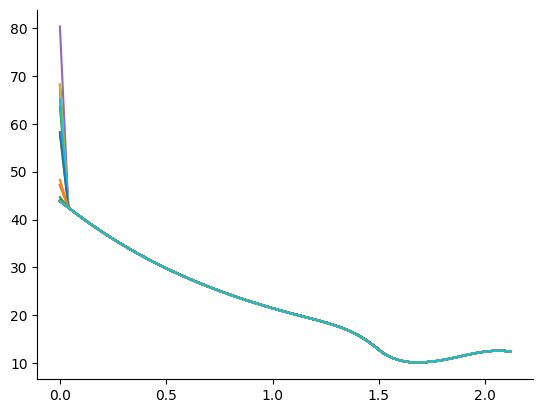

In [13]:
plt.plot(y1_grid_cap, ems)
plt.show()

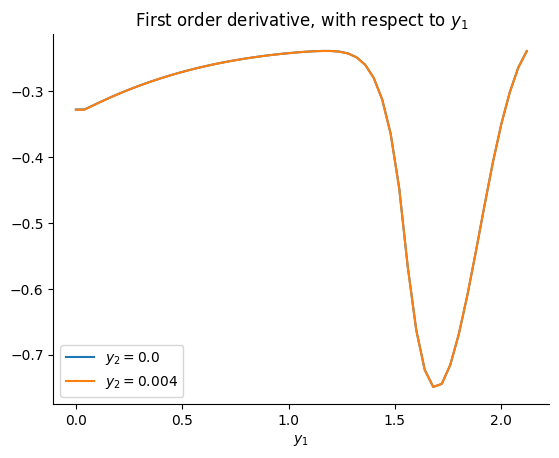

In [14]:
plt.title("First order derivative, with respect to $y_1$")
plt.plot(y1_grid_cap, v0_dy1[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy1[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy1")
plt.show()

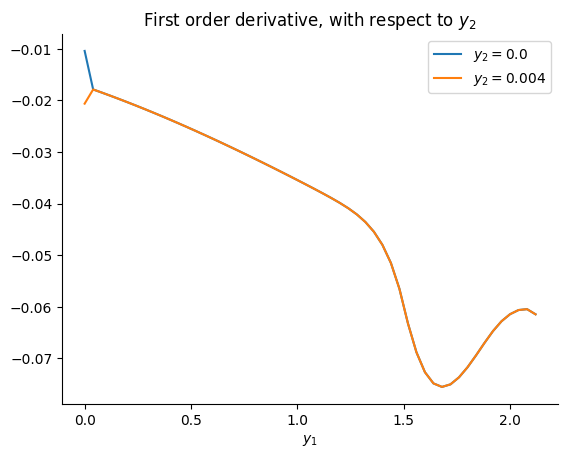

In [15]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y1_grid_cap, v0_dy2[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy2[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy2")
plt.show()

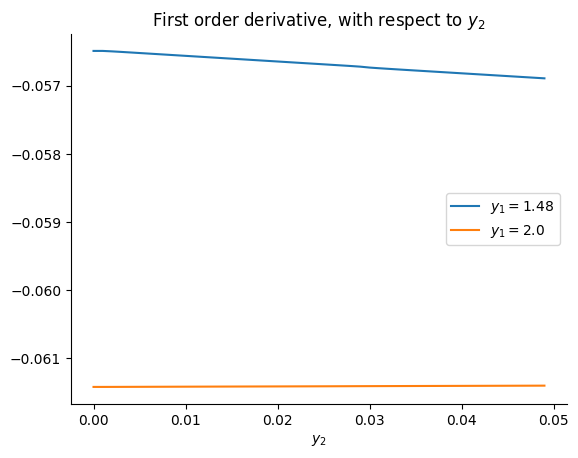

In [16]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y2_grid, v0_dy2[37], label=r"$y_1 = {}$".format(y1_grid_cap[37]))
plt.plot(y2_grid, v0_dy2[-4], label=r"$y_1 = {}$".format(y1_grid_cap[-4]))
plt.xlabel(r"$y_2$")
plt.legend()
# plt.savefig("dv_dy2_y2")
plt.show()

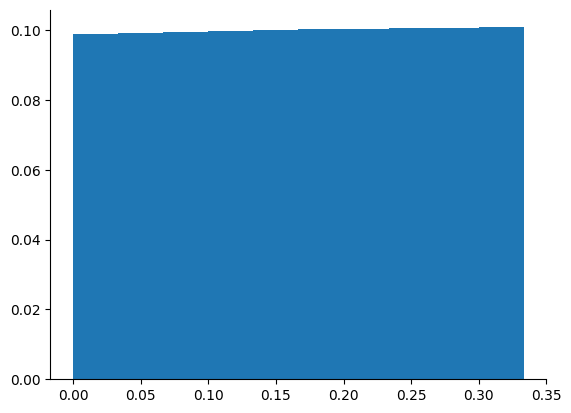

In [17]:
g_i = g_m[:, -1, 2]
plt.hist(γ3_list, weights= g_i/ np.sum(g_i, axis=0))
plt.show()

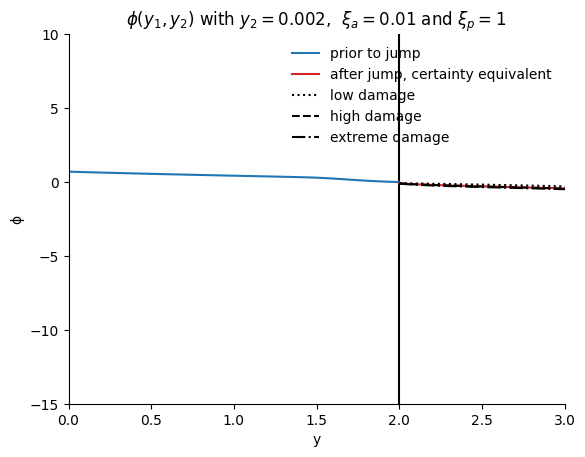

In [18]:
#
plt.plot(y1_grid[:loc_2 + 1],
         phi_mat[:loc_2 + 1, 2],
         color="tab:blue",
         label="prior to jump")
plt.plot(y1_grid[loc_2:],
         ϕ_equiv[loc_2:][:, 2],
         color="tab:red",
         label="after jump, certainty equivalent")
plt.plot(y1_grid[loc_2:],
         ϕ_list[0][loc_2:, 2],
         color="black",
         linestyle=":",
         label="low damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[10][loc_2:, 2],
         color="black",
         linestyle="--",
         label="high damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[-1][loc_2:, 2],
         color="black",
         linestyle="-.",
         label="extreme damage")

plt.legend(frameon=False)
plt.title("$ϕ(y_1, y_2)$ with $y_2 = 0.002$,  $ξ_a = 0.01$ and $ξ_p = 1$")
plt.vlines(2, ymax=10, ymin=-15, color="black")
plt.xlim(0, 3)
plt.ylim(-15, 10)
plt.xlabel("y")
plt.ylabel("ϕ")
# plt.savefig("./paper_plots/2_state_value_function.png", dpi=400, facecolor="w", edgecolor="w", bbox_inches="tight")
plt.show()

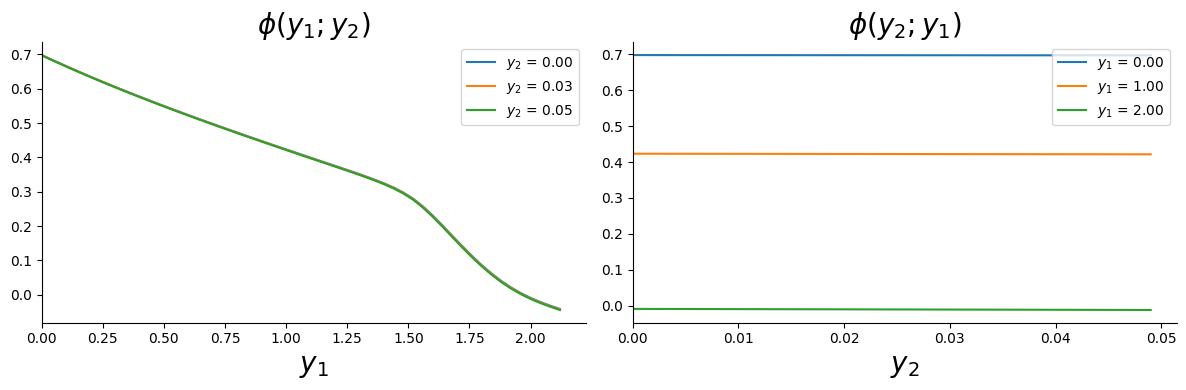

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], v0[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], v0[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], v0[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$ϕ(y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.legend()
# ax1.tick_params(labelsize=20)
ax1.set_xlim(0)
# ax1.set_ylim(-0.18, 0.05)
ax2.plot(y2_mat[0], v0[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1 / 4)], v0[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1 / 2)], v0[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
# ax2.plot(y2_mat[-1], v0[-1], label="$y_1$ = {:.2f}".format(y1_mat[-1,0]))
ax2.set_title('$ϕ(y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.legend()
# ax2.set_ylim(-0.18, 0.05)
fig.tight_layout()
# plt.savefig("ϕ.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

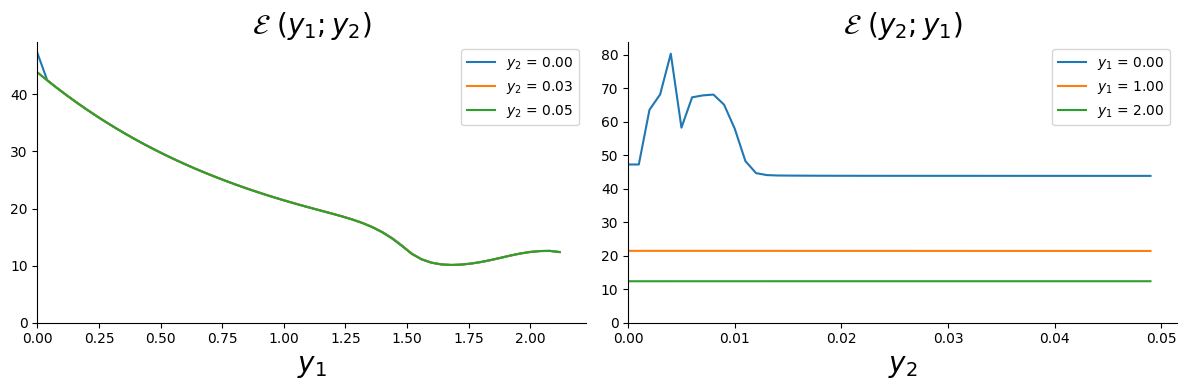

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], ems[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], ems[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], ems[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$\mathcal{E}\ (y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.set_xlim(0)
ax1.set_ylim(0)
ax1.legend()
# ax1.set_ylim(0, 12)
ax2.plot(y2_mat[0], ems[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1/4)], ems[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1/2)], ems[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
ax2.set_title('$\mathcal{E}\ ( y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.set_ylim(0)
ax2.legend()
# ax2.set_ylim(0,12)
fig.tight_layout()
# plt.savefig("E.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

In [21]:
from scipy import interpolate
def simualte_ems(y1_grid, y2_grid, ems, T=100, dt=1):
    periods = int(T/dt)
    Y1t = np.zeros(periods)
    Y2t = np.zeros(periods)
    ems_t = np.zeros(periods)
    f = interpolate.interp2d(y2_grid, y1_grid, ems, )
#     f_π = interpolate.interp2d(y2_grid, y1_grid, πa, )
    y1 = θ*290
    y2 = 0.00186
    for t in range(periods):
        if y1 > np.max(y1_mat) or y2 > np.max(y2_mat):
            break
        ems_point = f(y2, y1)
#         π_list = f_π(y2, y1)
        ems_t[t] = ems_point[0]
        Y1t[t] = y1
        Y2t[t] = y2
        y1 += y2*dt
        y2 += ( - λ*y2 + λ*θ*ems_point)*dt
    return Y1t, Y2t, ems_t

In [22]:
def simulation(y1_grid, y2_grid, e_grid, λ, θ=1.86/1000., y1_0=.5394, y2_0=1.86/1000, T=100):
    e_fun = interpolate.interp2d(y1_grid, y2_grid, e_grid.T)
    Et = np.zeros(T+1)
    y1t = np.zeros(T+1)
    y2t = np.zeros(T+1)
    for i in range(T+1):
#         y2_0 = max(y2_0, 0)
#         y2_0 = min(y2_0, 0.05)
        Et[i] = e_fun(y1_0, y2_0)
        y1t[i] = y1_0
        y2t[i] = y2_0
        y2_0 = np.exp(-λ)*y2_0 + (1 - np.exp(-λ))*θ*Et[i] 
#         y2_0 = max(y2_0, 0)
        y1_0 = y1_0 + y2_0
    return Et, y1t, y2t

In [23]:
def simulation_1d(y_grid, e_grid, θ=1.86/1000., y_0=1.1, T=100):
    e_fun = interpolate.interp1d(y_grid, e_grid)
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = e_fun(y_0)
        yt[i] = y_0
        y_0 = y_0 + θ*Et[i] 
    return Et, yt

In [24]:
ems_1state = np.load("ems_1state.npy")
# ems_2state = np.load("ems_2state.npy")

In [25]:
i = 0
et1, yt1 = simulation_1d(np.arange(0, 5 + 0.01,  0.01), ems_1state[0], θ=np.mean(θ_list), y_0=2)
et2, y1t2, y2t2 = simulation(y1_grid, y2_grid, ems_list[0], λ, θ=np.mean(θ), y1_0=2)

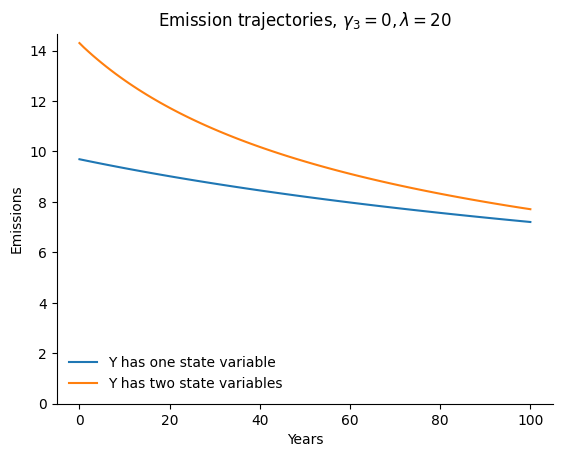

In [26]:
plt.title(f"Emission trajectories, $γ_3 = 0, λ = {λ}$")
plt.plot(et1, label="Y has one state variable")
plt.plot(et2, label="Y has two state variables")
plt.legend(frameon=False, loc=3)
plt.ylim(0)
plt.ylabel("Emissions")
plt.xlabel("Years")
# plt.savefig("ems_1_2_5")
plt.show()

In [49]:
et_prejump, y1t_prejump, y2t_prejump = simulation(y1_grid_cap,
                                                  y2_grid,
                                                  ems,
                                                  λ,
                                                  θ=np.mean(θ_list),
                                                  y1_0 = 1.1,
                                                  y2_0=np.mean(θ_list),
                                                  T=37
                                                 )

In [50]:
y1t_prejump

array([1.1       , 1.13769269, 1.17452713, 1.21056935, 1.24582605,
       1.28028198, 1.31389693, 1.34657143, 1.37818509, 1.40860315,
       1.43769442, 1.46532416, 1.49130497, 1.51565954, 1.53842171,
       1.56007091, 1.58074506, 1.60085644, 1.62043059, 1.63972677,
       1.6587486 , 1.67768225, 1.69653071, 1.71541505, 1.73435234,
       1.7534222 , 1.77265118, 1.79209497, 1.8117846 , 1.83176277,
       1.8520607 , 1.87271067, 1.89373764, 1.91515422, 1.93697068,
       1.95915968, 1.98171737, 2.00456148])

In [55]:
simul = {
    "et": et_prejump,
    "y1t": y1t_prejump,
    "y2t": y2t_prejump,
}

pickle.dump(simul, open(f"simul_{λ}", "wb"))

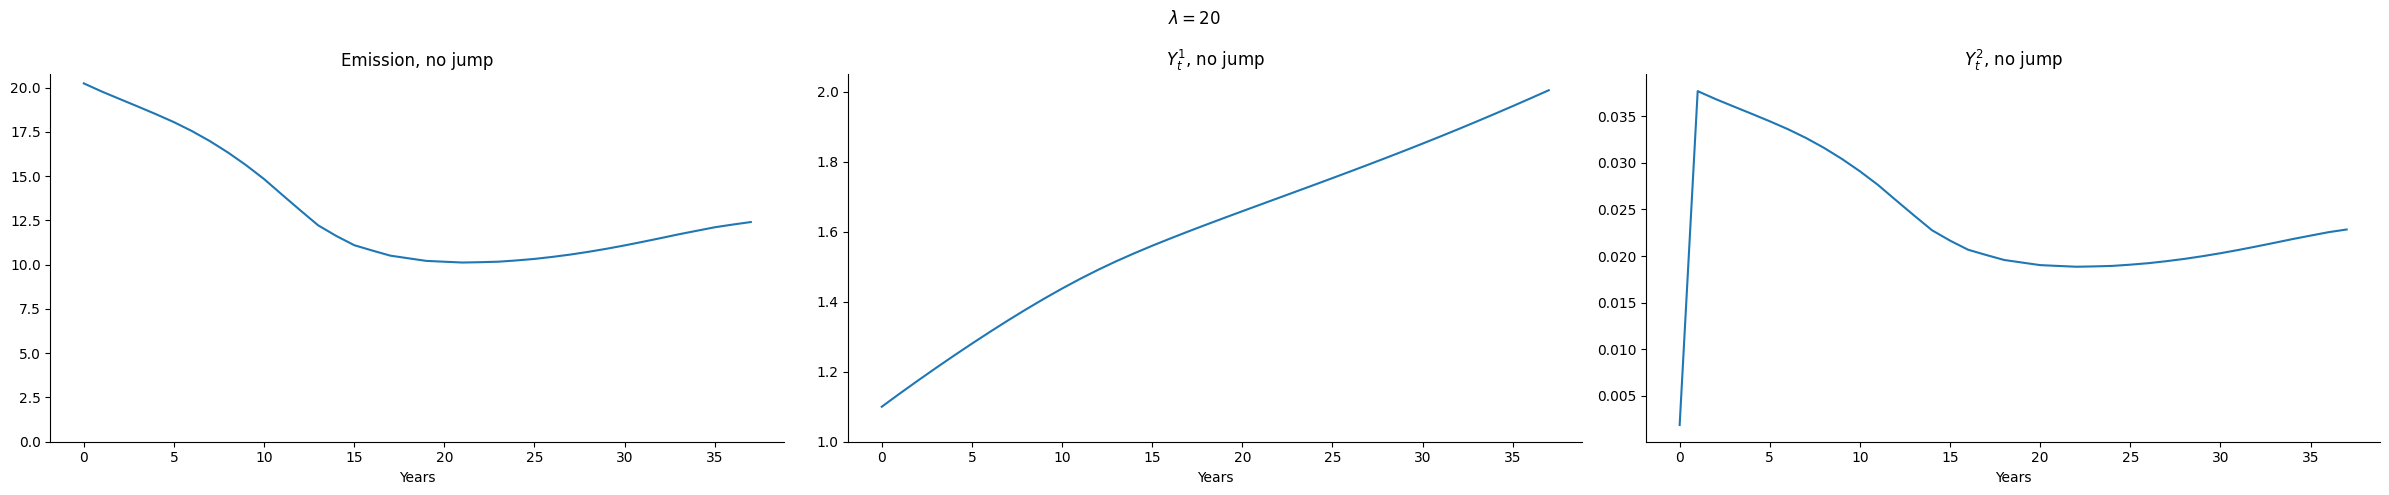

In [57]:
fig = plt.figure(figsize=(24, 5))
fig.suptitle(f"$\lambda = {λ}$")
plt.subplot(131)
plt.title("Emission, no jump")
plt.plot(et_prejump)
plt.ylim(0)
plt.xlabel("Years")
plt.subplot(132)
plt.xlabel("Years")
plt.title(r"$Y_t^1$, no jump")
plt.plot(y1t_prejump)
plt.ylim(1)
plt.subplot(133)
plt.title(r"$Y_t^2$, no jump")
plt.plot(y2t_prejump)
# plt.ylim(0, 0.02)
plt.xlabel("Years")
plt.tight_layout()
# plt.savefig(f"e_y1_y2_{λ}")
plt.show()

In [53]:
y2t_prejump.max(), y2_grid[-1], y1t_prejump

(0.03769269493738043,
 0.049,
 array([1.1       , 1.13769269, 1.17452713, 1.21056935, 1.24582605,
        1.28028198, 1.31389693, 1.34657143, 1.37818509, 1.40860315,
        1.43769442, 1.46532416, 1.49130497, 1.51565954, 1.53842171,
        1.56007091, 1.58074506, 1.60085644, 1.62043059, 1.63972677,
        1.6587486 , 1.67768225, 1.69653071, 1.71541505, 1.73435234,
        1.7534222 , 1.77265118, 1.79209497, 1.8117846 , 1.83176277,
        1.8520607 , 1.87271067, 1.89373764, 1.91515422, 1.93697068,
        1.95915968, 1.98171737, 2.00456148]))

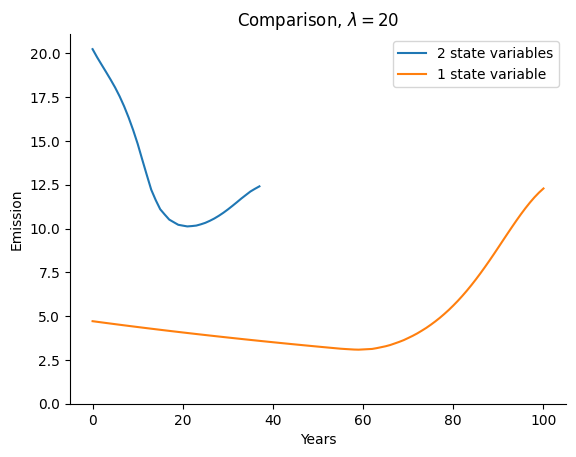

In [54]:
et_1state = np.load("et_1state.npy")
plt.plot(et_prejump, label="2 state variables")
plt.plot(et_1state, label="1 state variable")
plt.ylim(0)
plt.legend()
plt.xlabel("Years")
plt.ylabel("Emission")
plt.title(f'Comparison, $\lambda = {λ}$')
# plt.savefig(f"emissions_2_{λ}")
plt.show()

In [71]:

# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt

In [72]:
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0095
κ = 6.667
k0 = 85/α

In [73]:
Kt = simulate_logkapital(invkap, αₖ, σₖ, κ,  k0, T=90)
MC = δ*(1-η)/((α - invkap)*np.exp(Kt))
scc = η*(α - invkap)*np.exp(Kt)/(1-η)/et_prejump*1000

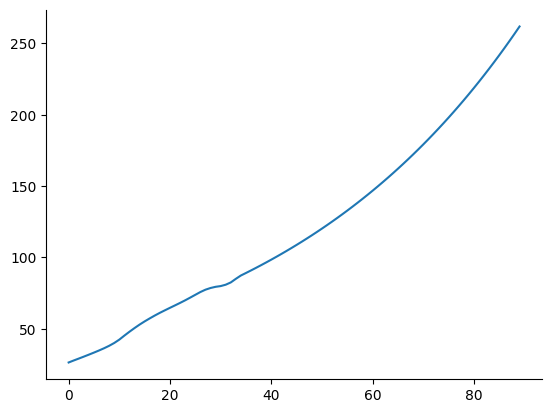

In [74]:
plt.plot(scc)
plt.show()

In [60]:
np.save(f"scct_{λ}", scc)